In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Descomprimimos el archivo en el que tenemos todos los datos necesarios para la práctica
!unzip /content/drive/MyDrive/Datos/Practica1/archive-intel.zip

Archive:  /content/drive/MyDrive/Datos/Practica1/archive-intel.zip
replace archive-intel/seg_test/seg_test/buildings/20057.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Preparación de las imagenes en crudo en su representación en tensor
from keras.preprocessing.image import ImageDataGenerator
#Con este generador, podremos recorrer los datos en lotes, y en cada iteración, el generador aplicará
#las técnicas de aumento de datos especificadas para generar imágenes aumentadas

In [ ]:
#Para normalizar los valores de los píxeles en las imágenes
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    '/content/archive-intel/seg_train/seg_train', #Ruta del directorio donde se encuentran las imágenes de entrenamiento
    target_size=(200, 200), #Las imágenes se redimensionarán a una altura y ancho de 200 píxeles
    batch_size=32, #Número de imágenes en cada lote que se utilizará para el entrenamiento
    class_mode='categorical') #Tarea de clasificación categórica (multiclase)

Found 14034 images belonging to 6 classes.


In [ ]:
validation_generator = test_datagen.flow_from_directory(
    '/content/archive-intel/seg_test/seg_test', #Ruta del directorio donde se encuentran las imágenes de prueba o validación
    target_size=(200, 200), #Las imágenes se redimensionarán a una altura y ancho de 200 píxeles
    batch_size=32, #Número de imágenes en cada lote que se utilizará para la validación
    class_mode='categorical') #Tarea de clasificación categórica (multiclase)

Found 3000 images belonging to 6 classes.


In [ ]:
# Vemos el contenido de uno de los generators e imprimimos la forma (shape) del lote de datos y el lote de etiquetas
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 200, 200, 3)
labels batch shape: (32, 6)


In [ ]:
# Construimos el modelo
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers

In [ ]:
model = models.Sequential()
#Convoluciones en la entrada con 128 filtros, cada uno de tamaño 5x5, utilizando la función de activación relu
#La entrada esperada tiene una forma de (200, 200, 3), que son las dimensiones de las imágenes
#padding='same' ==> aplicar relleno (padding) a la entrada de manera que la salida tenga la misma altura y ancho que la entrada original
model.add(layers.Conv2D(128, (5, 5), padding='same', activation='relu', input_shape=(200, 200, 3)))
#Para reducir las dimensiones espaciales de la salida de la capa anterior
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (5, 5), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (5, 5), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten()) #Aplana la salida de la capa anterior para convertirla en un vector unidimensional, preparándola para las capas densas
model.add(layers.Dense(64, activation='relu')) #Agregamos una capa densa con 64 neuronas y función de activación ReLU
model.add(layers.Dropout(0.2)) #Agregamos capa Dropout() para evitar overfitting
model.add(layers.Dense(256, activation='relu')) #Otra capa densa con 256 neuronas y activación ReLU
model.add(layers.Dense(6, activation='softmax')) #Capa de salida con 6 neuronas (tenemos 6 clases), y función de activación softmax porque es clasificación multiclase

In [ ]:
# Resumen del modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 200, 200, 128)     9728      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 100, 100, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 64)      204864    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 50, 50, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 50, 128)       204928    
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 25, 25, 128)      

In [ ]:
# Configuración del modelo para entrenamiento
from tensorflow.keras import optimizers

#La entropía cruzada categórica ('categorical_crossentropy') es comúnmente utilizada en este tipo de problemas (multiclase)
#Utilizamos como optimizador 'RMSprop' con tasa de aprendizaje de 0.0001
#Monitoreamos la precisión durante el entrenamiento
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])

In [ ]:
# Vamos a entrenar la red neuronal con el generator que configuramos más arriba
history = model.fit_generator(train_generator, steps_per_epoch=438, epochs=10, validation_data=validation_generator, validation_steps=93)

Epoch 1/10


<ipython-input-16-d39f8d8418d6>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=438, epochs=10, validation_data=validation_generator, validation_steps=93)


438/438 [==============================] - 56s 123ms/step - loss: 1.2017 - acc: 0.5255 - val_loss: 0.9680 - val_acc: 0.6169
Epoch 2/10
438/438 [==============================] - 55s 125ms/step - loss: 0.9430 - acc: 0.6303 - val_loss: 0.8288 - val_acc: 0.6643
Epoch 3/10
438/438 [==============================] - 54s 124ms/step - loss: 0.8364 - acc: 0.6760 - val_loss: 0.7405 - val_acc: 0.7063
Epoch 4/10
438/438 [==============================] - 53s 120ms/step - loss: 0.7210 - acc: 0.7326 - val_loss: 0.6319 - val_acc: 0.7762
Epoch 5/10
438/438 [==============================] - 54s 123ms/step - loss: 0.6340 - acc: 0.7716 - val_loss: 0.6444 - val_acc: 0.7749
Epoch 6/10
438/438 [==============================] - 53s 121ms/step - loss: 0.5788 - acc: 0.7982 - val_loss: 0.5840 - val_acc: 0.7893
Epoch 7/10
438/438 [==============================] - 53s 121ms/step - loss: 0.5230 - acc: 0.8155 - val_loss: 0.4803 - val_acc: 0.8360
Epoch 8/10
438/438 [==============================] - 53s 120ms/st

# Vamos a ver las graficas de entrenamiento

In [ ]:
history_dict = history.history

In [ ]:
#Para obtener las claves disponibles en este diccionario
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

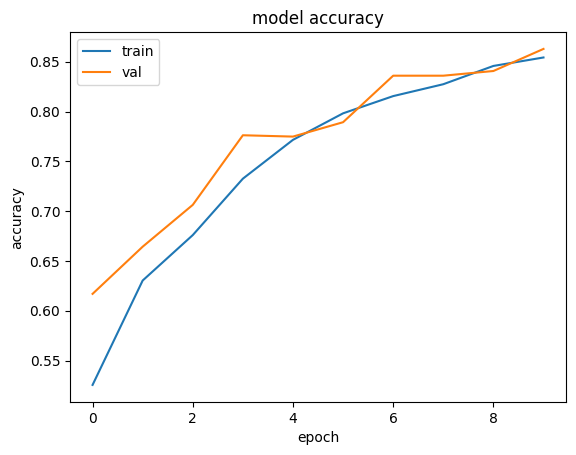

In [ ]:
#Gráfica de la precisión del modelo
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy') #Eje y (accuracy): Representa la precisión del modelo
plt.xlabel('epoch') #Eje x (epoch): Representa las épocas del entrenamiento
plt.legend(['train', 'val'], loc='upper left')
plt.show()

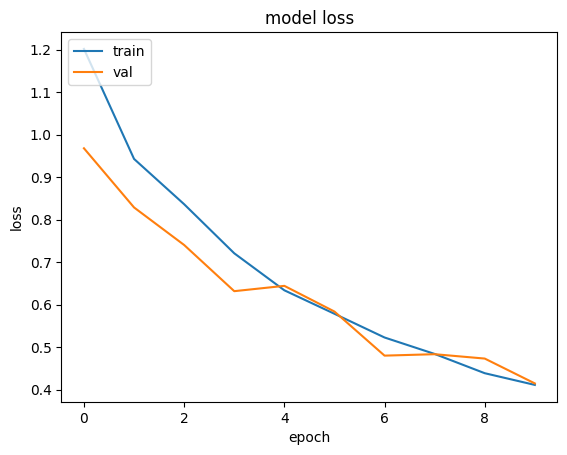

In [ ]:
#Gráfica de la pérdida del modelo
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss') #Eje y (loss): Representa la pérdida del modelo
plt.xlabel('epoch') #Eje x (epoch): Representa las épocas del entrenamiento
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#Para evaluar el rendimiento del modelo en un conjunto de datos que no se ha visto durante el entrenamiento
test_generator = test_datagen.flow_from_directory(
    '/content/archive-intel/seg_test/seg_test', #Ruta del directorio donde se encuentran las imágenes de prueba
    target_size=(200, 200), #Las imágenes se redimensionarán a una altura y ancho de 200 píxeles
    batch_size=32, #Número de imágenes en cada lote que se utilizará para la evaluación
    class_mode='categorical') #Tarea de clasificación categórica (multiclase)

Found 3000 images belonging to 6 classes.


In [ ]:
#Estimar la preción al predecir todo el dataset, es decir, evaluamos el rendimiento final del modelo en datos no vistos
scores = model.evaluate(test_generator)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

94/94 [==============================] - 8s 90ms/step - loss: 0.4160 - acc: 0.8630
acc: 86.30%
